In [9]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
import pandas as pd
import numpy as np
import io
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import math
import random
from captum.attr import IntegratedGradients
import pickle

In [10]:
def one_hot_smile(smile):
    key="()+–./-0123456789=#@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]abcdefghijklmnopqrstuvwxyz^$"
    test_list=list(key)
    res = {val : idx  for idx, val in enumerate(test_list)}
    #smile="^"+smile
    smile="^"+smile+("$"*(299-len(smile)))
    array=[[0 for j in range(len(key))] for i in range(300)]
    for i in range(len(smile)):
        array[i][res[smile[i]]]=1
    array=torch.Tensor(array)
    return array


In [11]:
def one_hot_seq(seq):
    key="^ABCDEFGHIJKLMNOPQRSTUVWXYZ$"
    seq=seq.upper()
    test_list=list(key)
    res = {val : idx  for idx, val in enumerate(test_list)}
    #seq="^"+seq+"$"
    seq="^"+seq+("$"*(399-len(seq)))
    array=[[0 for j in range(len(key))] for i in range(400)]
    for i in range(len(seq)):
        array[i][res[seq[i]]]=1
    array=torch.Tensor(array)
    return array

In [12]:
class BLSTM(nn.Module):
    def __init__(self, input_smile_dim, hidden_smile_dim, layer_smile_dim,input_seq_dim, hidden_seq_dim, layer_seq_dim, output_dim):
        super(BLSTM, self).__init__()
        self.hidden_smile_dim = hidden_smile_dim
        self.layer_smile_dim = layer_smile_dim
        self.hidden_seq_dim = hidden_seq_dim
        self.layer_seq_dim = layer_seq_dim
        self.output_dim = output_dim
        self.smile_len = 300
        self.seq_len = 400
        self.num_smile_dir=2
        self.num_seq_dir=2
        
        self.lstm_smile = nn.LSTM(input_smile_dim, hidden_smile_dim, layer_smile_dim,bidirectional=True)
        self.lstm_seq = nn.LSTM(input_seq_dim, hidden_seq_dim, layer_seq_dim,bidirectional=True)
        self.dropout = nn.Dropout(p=0.1)
        self.fc_smile= nn.Linear(self.smile_len*hidden_smile_dim*self.num_smile_dir,50)
        self.fc_seq= nn.Linear(self.seq_len*hidden_seq_dim*self.num_seq_dir,50)
        
        self.fc_combined = nn.Sequential(nn.Linear(100,10),nn.ReLU(),nn.Linear(10,output_dim))

    def forward(self, x1,x2):
        h0_smile = torch.zeros(self.layer_smile_dim*self.num_smile_dir, x1.size(1), self.hidden_smile_dim).requires_grad_()
        c0_smile = torch.zeros(self.layer_smile_dim*self.num_smile_dir, x1.size(1), self.hidden_smile_dim).requires_grad_()
        h0_seq = torch.zeros(self.layer_seq_dim*self.num_seq_dir, x2.size(1), self.hidden_seq_dim).requires_grad_()
        c0_seq = torch.zeros(self.layer_seq_dim*self.num_seq_dir, x2.size(1), self.hidden_seq_dim).requires_grad_()

        out_smile, (hn_smile, cn_smile) = self.lstm_smile(x1, (h0_smile, c0_smile))
        out_seq, (hn_seq, cn_seq) = self.lstm_seq(x2, (h0_seq, c0_seq))
        out_smile = self.dropout(out_smile)
        out_seq = self.dropout(out_seq)
        out_smile=self.fc_smile(out_smile.view(-1,self.smile_len*self.hidden_smile_dim*self.num_smile_dir))
        out_seq=self.fc_seq(out_seq.view(-1,self.seq_len*self.hidden_seq_dim*self.num_seq_dir))
        out_smile = self.dropout(out_smile)
        out_seq = self.dropout(out_seq)
        #out_combined=torch.cat(out_smile,out_seq)
        out_combined=torch.cat((out_smile,out_seq), 1)
        out_combined=self.fc_combined(out_combined)

        prob=nn.Softmax(dim=1)(out_combined)
        pred=nn.LogSoftmax(dim=1)(out_combined)
        return pred


In [13]:
def user_predict(model, x_input_smile, x_input_seq):
    x_user_smile=one_hot_smile(x_input_smile)
    x_user_smile=list(x_user_smile)
    x_user_smile=torch.stack(x_user_smile)
    x_user_smile=x_user_smile.view(1,300,77)

    x_user_seq=one_hot_seq(x_input_seq)
    x_user_seq=list(x_user_seq)
    x_user_seq=torch.stack(x_user_seq)
    x_user_seq=x_user_seq.view(1,400,28)

    scores = model(x_user_smile,x_user_seq)
    _, predictions = scores.max(1)
    print("Prediction is ", predictions.item())

    prob=torch.exp(scores)
    prob=prob.tolist()
    print("Probability is",  prob[0][predictions.item()] )


    ig = IntegratedGradients(model)
    x_user_smile.requires_grad_()
    baseline = torch.zeros(1, 300, 77)
    for i in baseline[0]:
        i[-1]=1

    attr,delta= ig.attribute(x_user_smile,baselines=baseline, target=1,additional_forward_args =x_user_seq,return_convergence_delta=True)
    attr=attr.view(300,77)
    maxattr,_=torch.max(attr,dim=1)
    minattr,_=torch.min(attr,dim=1)
    relevance=maxattr+minattr
    relevance=relevance.detach().numpy()
    data_relevance=pd.DataFrame()
    data_relevance["values"]=relevance

    len_smile=len(x_input_smile)
    cropped_smile_relevance=data_relevance.iloc[0:len_smile]
    x_smile_labels=pd.Series(list(x_input_smile))
    cropped_smile_relevance['smile_char']=x_smile_labels
    impacts=[]
    for row in range(len_smile):
        if (ord(cropped_smile_relevance['smile_char'][row])<65 or ord(cropped_smile_relevance['smile_char'][row])>90):
            cropped_smile_relevance['values'][row]=0
        else:
            impacts.append(cropped_smile_relevance['values'][row])
    impacts=np.array(impacts)
    print(impacts)
    ax = cropped_smile_relevance['values'].plot(kind='bar',figsize=(20,10) ,color=(data_relevance['values'] > 0).map({True: 'g',False: 'r'}))
    ax.set_xticklabels(cropped_smile_relevance['smile_char'])
    ax.set_xlabel("Smiles")
    ax.set_ylabel("Relevance")
    ax.figure.savefig('barplot.png')
    
    mol=x_input_smile
    m = Chem.MolFromSmiles(mol)
    num_atoms = m.GetNumAtoms()
    labels = [ m.GetAtomWithIdx(i).GetSymbol().upper() for i in range(num_atoms) ]
    colors = {}
    i=0
    k=0
    y_max = np.max(impacts)
    y_min = np.min(impacts)
    dist = y_max - y_min
    while i < len(mol):
        c = mol[i]
        n = ""
        if c.upper() not in "CBONSPFIK":
            print(mol[i], 0.0, "0xFFFFFF")
        else:       
            if i + 1 < len(mol):
                n = mol[i+1]
            sym = c + n    
            sym = sym.strip()
            com = sym.upper()
            if com == "BR" or com == "CL" or com == "NA":
                i = i + 1
            else:
                com = c.upper()
                sym = c
            if com == labels[k]:
                color = "0xBBBBBB"
                triple = [0, 0 ,0]
                if impacts[k] > 0.0:
                    y = int(math.floor(255.0 - 155.0 * impacts[k]  / y_max))
                    color = "0x00" + hex(y)[-2:] + "00"
                    triple[1] = y /255.0
                if impacts[k] < 0.0:
                    y = int(math.floor(255.0 - 155.0 * impacts[k]  / y_min))
                    color = "0x" + hex(y)[-2:] + "0000"
                    triple[0] = y / 255.0
                colors[k]= tuple(triple)
                print(sym, impacts[k], color)
                k = k + 1   
        i = i + 1
    drawer = rdMolDraw2D.MolDraw2DSVG(400, 400)

    drawer.DrawMolecule(m,highlightAtoms = [i for i in range(num_atoms)], highlightBonds=[], highlightAtomColors = colors)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText().replace('svg:','')

    fp = open("mol.svg", "w")
    print(svg, file=fp)
    fp.close()

In [14]:
filename = 'M4.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [15]:
user_smile='CCCCC(S)C(C)CO'
user_seq='MSFSSLPTEIQSLLFLTFLTIYLVTLMGNCLIILVTLADPMLHSPMYFFLRNLSFLEIGFNLVIVPKMLGTLLAQDTTISFLGCATQMYFFFFFGVAECFLLATMAYDRYVAICSPLHYPVIMNQRTRAKLAAASWFPGFPVATVQTTWLFSFPFCGTNKVNHFFCDSPPVLRLVCADTALFEIYAIVGTILVVMIPCLLILCSYTHIAAAILKIPSAKGKNKAFSTCSSHLLVVSLFYISLSLTYFRPKSNNSPEGKKLLSLSYTVMTPMLNPIIYSLRNNEVKNALSRTVSKALALRNCIP'

Prediction is  0
Probability is 0.9681814908981323
[ 8.80390251e-04  2.38381399e-01 -1.51162501e-03 -7.45731685e-01
 -1.25903817e+00 -7.18389641e-01 -1.46265517e-01  3.60718929e-01
 -3.03352367e-01  1.86774695e-01]


/home/ria/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ria/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ria/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

C 0.0008803902511527227 0x00fe00
C 0.23838139857994473 0x009800
C -0.0015116250066259315 0xfe0000
C -0.7457316847728624 0xa30000
C -1.2590381721422 0x640000
( 0.0 0xFFFFFF
S -0.718389640637631 0xa60000
) 0.0 0xFFFFFF
C -0.1462655170124543 0xec0000
( 0.0 0xFFFFFF
C 0.3607189287473681 0x006400
) 0.0 0xFFFFFF
C -0.3033523670402557 0xd90000
O 0.18677469508542333 0x00ae00


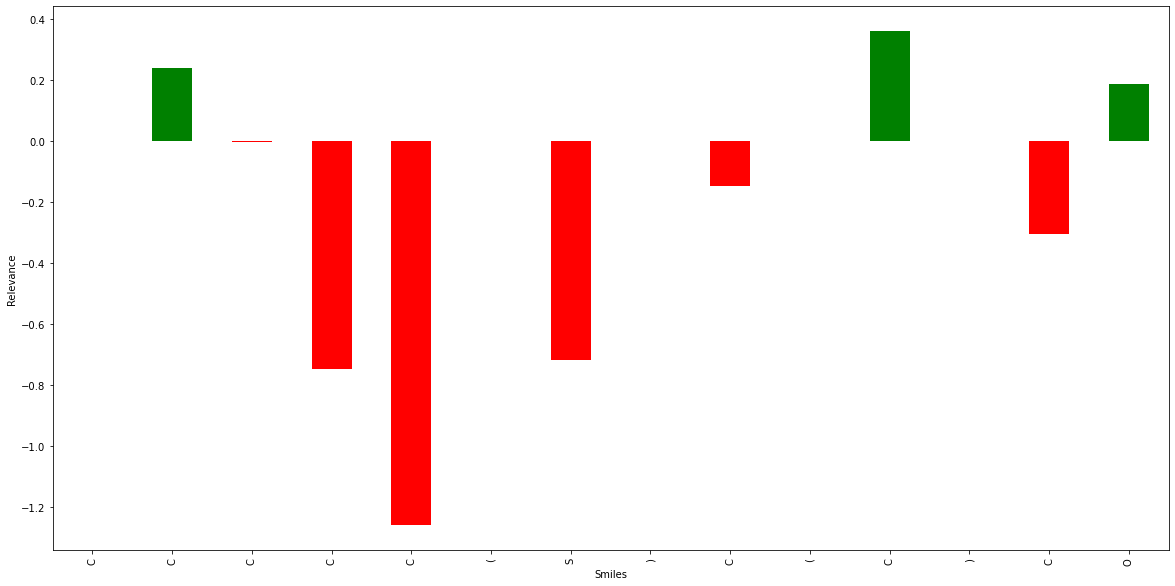

In [16]:
user_predict(loaded_model, user_smile,user_seq)
